# Welcome! It's a short description of my prediction algorithm.

The main idea is replace '-1' risk value by big value (bigger than risk of good batterise) - it helps regression predict more correctly: the longer life - the higher risk.

After that we predict battery health - binary variable: 0 - battery bad, 1 - battery good.

Next we use all this data to predict life expectancy for each batteries and finaly:
 - replace all values bigger than Threshold by -1;
 - if battery health == 0, replace prediction by 0;
 - replace negative predictions to near zero value.
 
This notebook generates the same predictions as 'topcoder_batteries.py'. Some probability of errors may appear if there will be some different categorial variable values ('event_country_code', 'batt_manufacturer') in train and test files.

To change train/test filenames just correct 'ftrain', 'fest' variables.

In [1]:
# importing all necesary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, confusion_matrix,\
                            accuracy_score, f1_score

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBRegressor, XGBClassifier
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# First look at the data

In [31]:
# read data from file
def ReadData(data_dir, fnames):
    df = pd.read_csv(data_dir + fname, parse_dates=['date'], index_col='date')
    return df

# manualy define wich files to process
data_dir = 'Data/'
ftrain = 'train.csv'
ftest = 'test.csv'
cat_features = ['event_country_code', 'batt_manufacturer', 'batt_instance']

# задаём размер рисунков
plt.rcParams['figure.figsize'] = (15,12)
sns.set()

df = pd.read_csv(data_dir + ftrain)
test_df = pd.read_csv(data_dir + ftest)

# adding 'OK' feature if risk != 0
df['OK'] = np.where(df['risk']==0, 0, 1)
# replace -1 to max risk value 450
df.loc[df.risk == -1, 'risk'] = 450
# how many good and bad batteries
df.OK.value_counts()

1    84289
0     2665
Name: OK, dtype: int64

In [3]:
# reading the data
df.head()

,event_country_code,batt_manufacturer,installed_count,batt_instance,cycle_count,temperature,battery_current,design_capacity,full_charge_capacity,remaining_capacity,design_voltage,batt_voltage,cell_voltage1,cell_voltage2,cell_voltage3,cell_voltage4,status_register,risk,OK
0,IV,33-24,1,primary,335,36,62999,4450,3473,1605,11400,12535,0,3457,3458,3447,192,450,1
1,JP,333-2B-0F,1,primary,16,22,63291,5200,4827,1801,7700,12535,0,0,3498,3512,192,450,1
2,US,333-1C-2F,1,primary,16,28,0,4080,3851,3707,11400,12535,0,4265,4265,4264,224,450,1
3,US,13-42,1,primary,371,20,237,4450,3293,3018,11400,12535,0,4325,4274,4277,128,450,1
4,IV,33-42,1,primary,63,33,0,4450,3819,3615,11400,12535,0,4245,4248,4246,224,450,1


In [4]:
# quick look at the data
df.describe()

,installed_count,cycle_count,temperature,battery_current,design_capacity,full_charge_capacity,remaining_capacity,design_voltage,batt_voltage,cell_voltage1,cell_voltage2,cell_voltage3,cell_voltage4,status_register,risk,OK
count,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000
mean,1.004865,163.042528,29.305242,17554.370357,4057.864745,3651.617223,3069.510040,11398.079789,12534.922120,303.895048,3928.965085,4089.479782,4055.003956,1485.880132,381.447708,0.969352
std,0.069578,157.054658,4.750972,28454.219297,1123.447969,1270.159188,1346.188191,1208.573139,8.406005,1071.784932,830.367850,284.959325,446.065275,5800.829904,135.327995,0.172364
min,1.000000,0.000000,0.000000,0.000000,2500.000000,1.000000,0.000000,3800.000000,11289.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,35.000000,26.000000,0.000000,4080.000000,3323.000000,1998.000000,11100.000000,12535.000000,0.000000,3921.000000,3968.000000,3954.000000,192.000000,429.000000,1.000000
50%,1.000000,97.000000,29.000000,173.000000,4080.000000,3799.000000,3362.000000,11400.000000,12535.000000,0.000000,4143.000000,4152.000000,4154.000000,224.000000,450.000000,1.000000
75%,1.000000,309.000000,32.000000,63343.000000,4450.000000,3978.000000,3790.000000,11400.000000,12535.000000,0.000000,4273.000000,4279.000000,4278.000000,224.000000,450.000000,1.000000
max,2.000000,983.000000,55.000000,65433.000000,79538.000000,79538.000000,27114.000000,15551.000000,12554.000000,4398.000000,4398.000000,4400.000000,4399.000000,49376.000000,450.000000,1.000000


In [5]:
# lets see how many unique values in categorial features
print ('unique manufacturer:', len(np.unique(df.batt_manufacturer)))
print ('unique country_code:', len(np.unique(df.event_country_code)))
print ('unique batt_instance:', len(np.unique(df.batt_instance)))

unique manufacturer: 80
unique country_code: 32
unique batt_instance: 2


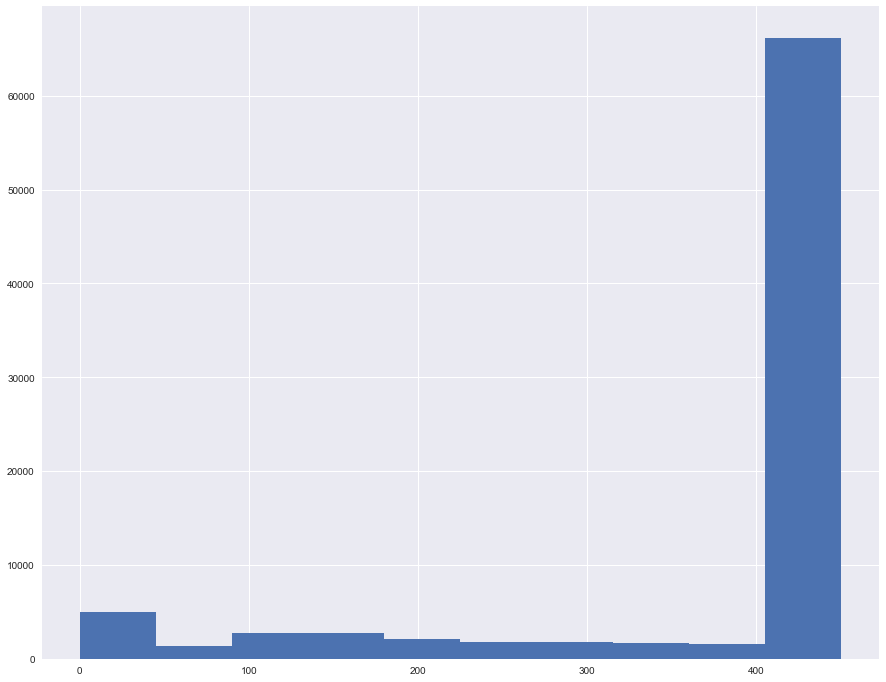

In [6]:
# risk distribution
df.risk.hist()

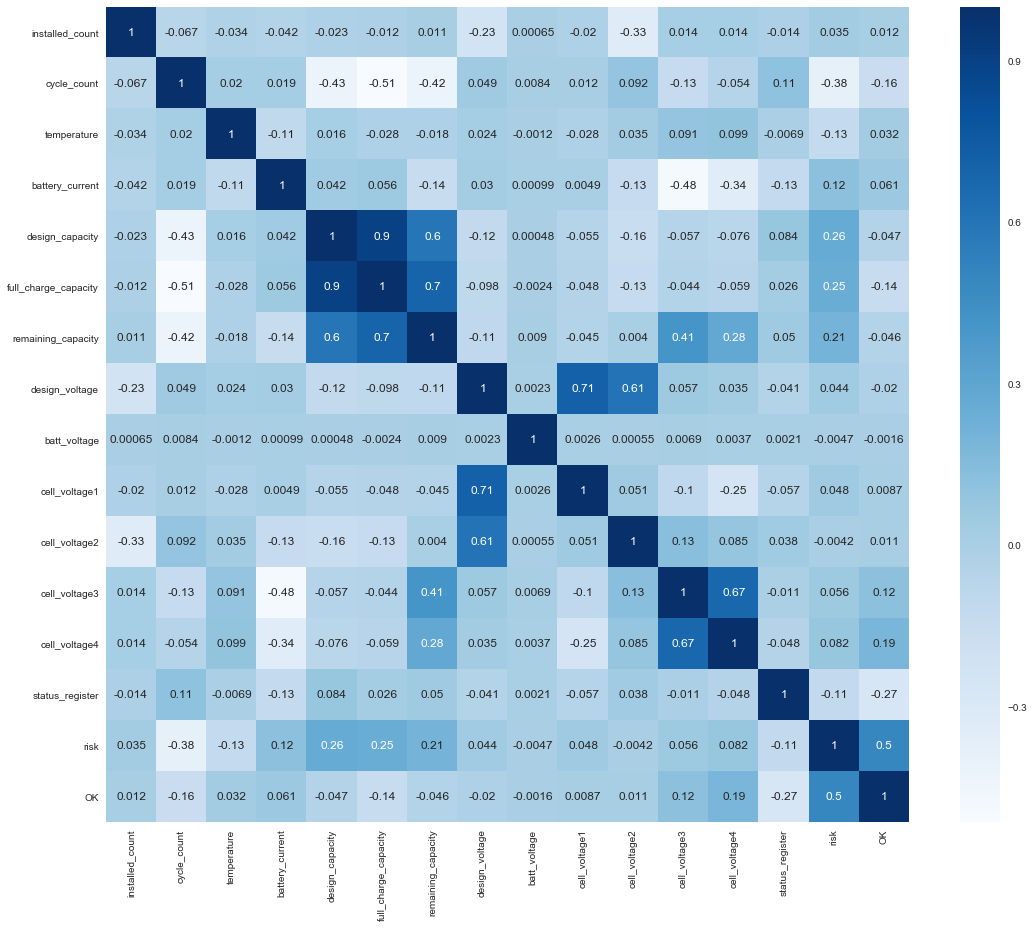

In [34]:
# features dependences
plt.rcParams['figure.figsize'] = (18,15)
sns.heatmap(df.corr(), annot=True, cmap = 'Blues')

Seems that no one feature powerfully affects to risk value. A little more than others 'cycle_counts', 'design_capacity' and 'full_charge_capacity' correlated to 'risk'. And we can say almost nothing about correlation between features and 'OK' variable with describes if a battery OK.

# Predict battery health

In [6]:
# split our data to train and test for classification task
no_cat_features_df = df.drop(cat_features, axis=1)

In [7]:
def TestPrediction(Xtrain, Xtest, ytrain, ytest, model, comment = None):
    # train model, make prediction and return score and conclusion matrix
    plt.rcParams['figure.figsize'] = (8,6)
    try:
        trained_model = model.fit_transform(Xtrain, ytrain)
    except Exception:
        # if model havn't fit_transform method
        trained_model = model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    print (comment)
    accuracy = accuracy_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    
    a = vstack((Xtrain,Xtest))
    b = hstack((ytrain, ytest))
    
    crossval_score = cross_val_score(model, a, y = b, cv = 5, scoring ='f1')
    print ('accuracy_score = ', accuracy)
    print ('f1_score       = ', f1)
    print ('cross val score= ', crossval_score, ' mean = ', crossval_score.mean())
    mat = confusion_matrix(ytest, y_pred)
    sns.heatmap(mat, square=True, annot=True, cbar=False, fmt = '5')
    plt.xlabel('predicted value') # Прогнозируемое значение
    plt.ylabel('true value'); # Настоящее значение
    
    return y_pred, model

baseline - LDA with no categorial features
accuracy_score =  0.9874419246515479
f1_score       =  0.9935422826729745
cross val score=  [0.99289899 0.99343855 0.99349343 0.99328502 0.99316588]  mean =  0.993256374999984
Wall time: 559 ms


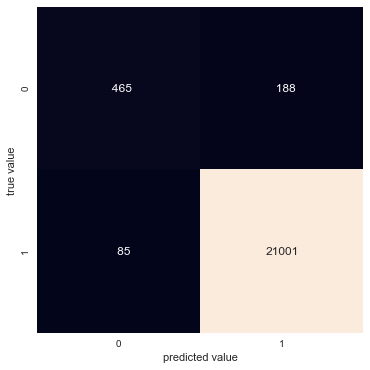

In [18]:
%%time
# as PCA explains more than 95% of dispersion try to use LDA for predict good batteries
Xtrain, Xtest, ytrain, ytest = train_test_split(no_cat_features_df.iloc[:, :-2], 
                                                no_cat_features_df.iloc[:, -1], random_state=1)
lda = LinearDiscriminantAnalysis(n_components = 2)

y_pred, lda_no_cat = TestPrediction(Xtrain, Xtest, ytrain, ytest, lda, 'baseline - LDA with no categorial features')

Too many false positive predictions. Thats because of good batteries much more than bad.

now lets try to use cat parametres

In [8]:
# encoding cat features and adding it to dataframe
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
encoded_cat_feat = vec.fit_transform(df[cat_features].T.to_dict().values())
cat_df = hstack((encoded_cat_feat, no_cat_features_df))

C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA with categorial features


C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


accuracy_score =  0.9897419384516307
f1_score       =  0.9947072366078845
cross val score=  [0.99415413 0.99370584 0.99364457 0.99397894 0.99468701]  mean =  0.9940340973658477
Wall time: 5.26 s


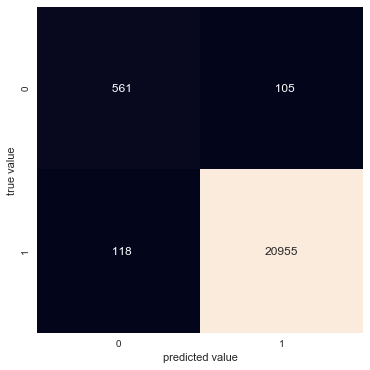

In [20]:
%%time
# LDA with catigorial features. Warnings are OK, its because some columns became correlated after adding cat features
bin_Xtrain, bin_Xtest, bin_ytrain, bin_ytest = train_test_split(cat_df[:, :-2], 
                                                                cat_df[:, -1], stratify = cat_df[:, -1], random_state=1)
bin_cat_pred, lda_cat = TestPrediction(bin_Xtrain, bin_Xtest, bin_ytrain, bin_ytest, lda, 'LDA with categorial features')

still to many false predictions. Lets try another classifier - XGBoost

C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgbCV with categorial features


C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

accuracy_score =  0.9995399972399834
f1_score       =  0.9997629320563273
cross val score=  [0.99985172 0.99958491 0.99970349 0.99970349 0.99973312]  mean =  0.9997153471596978
Wall time: 1min 46s


C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


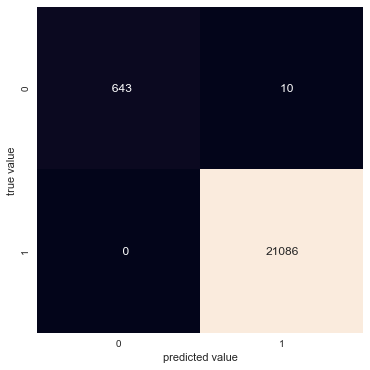

In [9]:
%%time
# trying XGBClassifier 
xgbCV = XGBClassifier()
bin_Xtrain, bin_Xtest, bin_ytrain, bin_ytest = train_test_split(cat_df[:, :-2], 
                                                                cat_df[:, -1], random_state=1)
bin_xgb_cat_pred, xgbCV_cat = TestPrediction(bin_Xtrain, bin_Xtest, bin_ytrain, bin_ytest, xgbCV, 'xgbCV with categorial features')

Scaling does not make sense. Categorial features increase f1 score a little.

XGB - rocks!

### Add prediction from classifier to learinig data

In [10]:
battery_OK_prediction = xgbCV_cat.predict(cat_df[:, :-2])
battery_OK_df = hstack((battery_OK_prediction.reshape(-1,1), cat_df))

C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Predict life expectancy

First we try xgboost with default parametres and if its OK, we tune hyperparametres to get better result

In [11]:
def RegressorPrediction(Xtrain, Xtest, ytrain, ytest, model, comment = None):
    # train model, make prediction and return score
    trained_model = model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    print (comment)
    score = explained_variance_score(ytest, y_pred)
    
    crossval_score = cross_val_score(model, Xtest, ytest, cv = 5, scoring ='explained_variance', n_jobs= -1)
    print ('score = ', score)
    print ('cross val score= ', crossval_score, ' mean = ', crossval_score.mean())
    
    return y_pred, model

In [12]:
%%time
# predict the risk!
Xtrain, Xtest, ytrain, ytest = train_test_split(battery_OK_df[:, :-2], battery_OK_df[:, -2], random_state=1)

xgb = XGBRegressor()
xgb_cat_pred, xgb_cat = RegressorPrediction(Xtrain, Xtest, ytrain, ytest, xgb, 'XGB with no categorial features')

XGB with no categorial features
score =  0.8320001164828142
cross val score=  [0.81589832 0.81104005 0.83198293 0.82849486 0.81832612]  mean =  0.8211484562340454
Wall time: 27.6 s


regression works fine. lets tune some parametres for better quality.

In [15]:
# tune main params of xfboost with GridSearchCV
from sklearn.model_selection import GridSearchCV
estimators = [600, 800, 1500]
learning_rates = [0.1, 0.05]
depths = [3, 5, 10]

In [10]:
%%time
# regression with cat features
Xtrain, Xtest, ytrain, ytest = train_test_split(battery_OK_df[:, :-2], 
                                                battery_OK_df[:, -2], random_state=1)

xgb_CV = GridSearchCV(XGBRegressor(),
                      scoring = 'explained_variance',
                      cv = 3,
                      n_jobs=-1,
                      verbose= 20,
                      param_grid={'n_estimators': estimators,
                                  'learning_rate': learning_rates,
                                  'max_depth': depths})

xgb_CV.fit(battery_OK_df[:, :-2], battery_OK_df[:, -2])

print (xgb_CV.best_params_)
print (xgb_CV.score(battery_OK_df[:, :-2], battery_OK_df[:, -2]))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 46.5min
[Paralle

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1500}
0.999996610242
Wall time: 18h 58min 16s


best parameters are:

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1500}

In [13]:
%%time
# lets refit regressor on a train data and compare with result above
Xtrain, Xtest, ytrain, ytest = train_test_split(battery_OK_df[:, :-2], battery_OK_df[:, -2], random_state=1)

xgb = XGBRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 1500, n_jobs= -1)
xgb_cat_pred, xgb_cat = RegressorPrediction(Xtrain, Xtest, ytrain, ytest, xgb, 'XGB with categorial features')

XGB with categorial features
score =  0.9735741430507169
cross val score=  [0.94265972 0.93784705 0.95249479 0.9364972  0.93890233]  mean =  0.9416802162729855
Wall time: 20min 55s


## much better with cat features. now make score function as in task

In [19]:
# if predicted value is bigger than 400 - battery will live long and happy
corr_pred = [-1 if val >= 440 else val for val in xgb_cat_pred]
corr_ytest = [-1 if val >= 440 else val for val in ytest]

# replace negative predictions to near zero value (1)
for i in range(len(bin_xgb_cat_pred)):
    if ((corr_pred[i] < -1) & (bin_xgb_cat_pred[i] == 1)) :
        corr_pred[i] = 1

# replace prediction for 'bad' batteries to 0
final_pred = []
for (p, batt_OK) in zip (corr_pred, bin_xgb_cat_pred):
    if batt_OK == 0:
        final_pred.append(0)
    elif (p > 0) and (p < 1):
        final_pred.append(int(1))
    else:
        final_pred.append(int(round(p)))

In [20]:
len(corr_ytest)

21739

In [21]:
len(final_pred)

21739

In [17]:
def battery_scorer(truth, pred):
    # scorer from topcoder
    if len(truth) != len(pred):
        return -1, -1, -1

    mat = [ [0, 0], [0, 0] ]
    MRAE, cnt = 0, 0
    for (t, p) in zip(truth, pred):
        mat[int(t == 0)][int(p == 0)] += 1
        if t > 0:
            cnt += 1
            if p == -1:
                MRAE += 1
            else:
                MRAE += min(1.0, abs(p - t) / t)

    MRAE /= cnt
    if mat[1][1] == 0:
        F1 = 0
    else:
        precision = float(mat[1][1]) / (mat[1][1] + mat[0][1])
        recall = float(mat[1][1]) / (mat[1][1] + mat[1][0])
        F1 = precision * recall * 2 / (precision + recall)

    return F1 + (1 - MRAE), F1, MRAE

In [23]:
# final result for training data
battery_scorer(corr_ytest, final_pred)

(1.950255075848688, 0.9907550077041603, 0.04049993185547202)

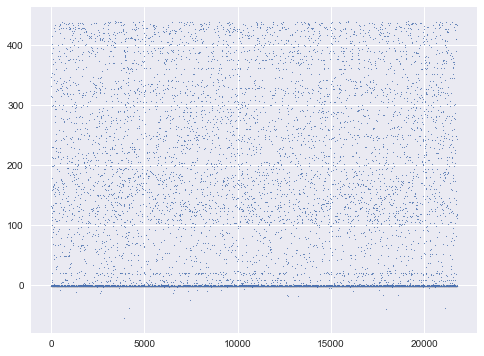

In [24]:
# distribution of predicted livetime
plt.scatter(range(len(corr_pred)), corr_pred, s=0.5)

# Predict life expectancy for the test file data

In [25]:
# split our data to train and test for classification task
no_cat_features_df = test_df.drop(cat_features, axis=1)
encoded_cat_feat = vec.transform(test_df[cat_features].T.to_dict().values())
cat_test_df = hstack((encoded_cat_feat, no_cat_features_df))

In [26]:
# applying XGBClassifier to test data
battery_OK_test_prediction = xgbCV_cat.predict(cat_test_df)
battery_OK_test_df = hstack((battery_OK_test_prediction.reshape(-1,1), cat_test_df))

# applying XGBRegressor to test data
xgb_test_cat_pred = xgb_cat.predict(battery_OK_test_df)

C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
corr_pred = [-1 if val >= 440 else val for val in xgb_test_cat_pred]

# replace negative predictions to near zero value (1)
for i in range(len(battery_OK_test_prediction)):
    if ((corr_pred[i] < -1) & (battery_OK_test_prediction[i] == 1)) :
        corr_pred[i] = 1

# replace prediction for 'bad' batteries to 0
final_pred = []
for (p, batt_OK) in zip (corr_pred, battery_OK_test_prediction):
    if batt_OK == 0:
        final_pred.append(0)
    elif (p > 0) and (p < 1):
        final_pred.append(int(1))
    else:
        final_pred.append(int(round(p)))

In [28]:
# write prediction to file
with open('prediction.csv', 'w') as the_file:
    the_file.write("%s\n" % 'RISK')
    for item in final_pred:
        the_file.write(str(int(item)) + '\n')

## OK, now its time to make all above in python file